# Chu de 1: Regression vs ARIMA - Khi nao chon cai nao?

## Muc tieu
- So sanh cong bang giua **Baseline Regression** (feature-based) va **ARIMA** (time-series-based)
- Danh gia hieu nang voi cung dieu kien: **tram Aotizhongxin**, **CUTOFF = 2017-01-01**, **HORIZON = 1 gio**
- Phan tich kha nang xu ly spike/dinh o nhiem cao
- Dua ra khuyen nghi trien khai thuc te

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set working directory to project root  
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks' or PROJECT_ROOT.name == 'runs':
    PROJECT_ROOT = PROJECT_ROOT.parent
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent
DATA_DIR = PROJECT_ROOT / 'data' / 'processed'

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
print(f'Project root: {PROJECT_ROOT}')
print(f'Data directory: {DATA_DIR}')

Project root: C:\Coding\DataMining\ThucHanh\Tuan7\Nhom12_Tuan7
Data directory: C:\Coding\DataMining\ThucHanh\Tuan7\Nhom12_Tuan7\data\processed


## 1. Load du lieu predictions tu ca 2 mo hinh

In [2]:
# Load ARIMA predictions
arima_preds = pd.read_csv(DATA_DIR / 'arima_pm25_predictions.csv', parse_dates=['datetime'])
arima_preds.set_index('datetime', inplace=True)
print(f'ARIMA predictions: {len(arima_preds)} rows')
print(f'Time range: {arima_preds.index.min()} to {arima_preds.index.max()}')

# Load Regression predictions (filter for Aotizhongxin only)
reg_preds = pd.read_csv(DATA_DIR / 'regression_predictions_sample.csv', parse_dates=['datetime'])
reg_preds_aoti = reg_preds[reg_preds['station'] == 'Aotizhongxin'].copy()
reg_preds_aoti.set_index('datetime', inplace=True)
print(f'Regression predictions (Aotizhongxin): {len(reg_preds_aoti)} rows')
print(f'Time range: {reg_preds_aoti.index.min()} to {reg_preds_aoti.index.max()}')

ARIMA predictions: 1416 rows
Time range: 2017-01-01 00:00:00 to 2017-02-28 23:00:00
Regression predictions (Aotizhongxin): 1399 rows
Time range: 2017-01-01 00:00:00 to 2017-02-28 22:00:00


In [3]:
# Load metrics summary
with open(DATA_DIR / 'arima_pm25_summary.json', 'r') as f:
    arima_metrics = json.load(f)
    
with open(DATA_DIR / 'regression_metrics.json', 'r') as f:
    reg_metrics_all = json.load(f)

print('ARIMA config:')
print(f'  - Station: {arima_metrics["station"]}')
print(f'  - CUTOFF: {arima_metrics["cutoff"]}')
print(f'  - Best order (p,d,q): {arima_metrics["best_order"]}')

print(f'Regression (all stations): RMSE={reg_metrics_all["rmse"]:.2f}, MAE={reg_metrics_all["mae"]:.2f}')

ARIMA config:
  - Station: Aotizhongxin
  - CUTOFF: 2017-01-01
  - Best order (p,d,q): [1, 0, 3]
Regression (all stations): RMSE=25.33, MAE=12.32


## 2. Merge du lieu de so sanh tren cung thoi diem

In [4]:
# Merge ARIMA va Regression predictions tren cung datetime
comparison = arima_preds[['y_true', 'y_pred']].copy()
comparison.columns = ['actual', 'arima_pred']

# Join voi regression predictions
comparison = comparison.join(reg_preds_aoti[['y_pred']], how='inner')
comparison.columns = ['actual', 'arima_pred', 'reg_pred']

print(f'So sanh tren {len(comparison)} thoi diem chung')
comparison.head(10)

So sanh tren 1399 thoi diem chung


,actual,arima_pred,reg_pred
datetime,,,
2017-01-01 00:00:00,485.0,460.796484,436.901040
2017-01-01 01:00:00,477.0,442.790204,444.198916
2017-01-01 02:00:00,454.0,425.685614,433.323668
2017-01-01 03:00:00,418.0,409.842475,371.884739
2017-01-01 04:00:00,438.0,394.729760,464.841039
2017-01-01 05:00:00,453.0,380.313793,435.241312
2017-01-01 06:00:00,433.0,366.562452,383.505606
2017-01-01 07:00:00,416.0,353.445095,388.150516
2017-01-01 08:00:00,421.0,340.932494,397.502465


## 3. Cau hoi 1: Mo hinh nao tot hon cho HORIZON = 1?

In [5]:
# Tinh metrics cho ca 2 mo hinh tren cung du lieu
arima_rmse = np.sqrt(mean_squared_error(comparison['actual'], comparison['arima_pred']))
arima_mae = mean_absolute_error(comparison['actual'], comparison['arima_pred'])

reg_rmse = np.sqrt(mean_squared_error(comparison['actual'], comparison['reg_pred']))
reg_mae = mean_absolute_error(comparison['actual'], comparison['reg_pred'])

print('=' * 60)
print('SO SANH CONG BANG: CUNG TRAM, CUNG CUTOFF, CUNG HORIZON = 1')
print('=' * 60)
print(f'{"Mo hinh":<20} {"RMSE":<15} {"MAE":<15}')
print('-' * 50)
print(f'{"ARIMA (1,0,3)":<20} {arima_rmse:<15.2f} {arima_mae:<15.2f}')
print(f'{"Regression":<20} {reg_rmse:<15.2f} {reg_mae:<15.2f}')
print('-' * 50)

# Ket luan
winner_rmse = 'Regression' if reg_rmse < arima_rmse else 'ARIMA'
winner_mae = 'Regression' if reg_mae < arima_mae else 'ARIMA'
improvement_rmse = abs(arima_rmse - reg_rmse) / arima_rmse * 100
improvement_mae = abs(arima_mae - reg_mae) / arima_mae * 100

print(f'>>> {winner_rmse} tot hon ve RMSE ({improvement_rmse:.1f}% improvement)')
print(f'>>> {winner_mae} tot hon ve MAE ({improvement_mae:.1f}% improvement)')

SO SANH CONG BANG: CUNG TRAM, CUNG CUTOFF, CUNG HORIZON = 1
Mo hinh              RMSE            MAE            
--------------------------------------------------
ARIMA (1,0,3)        104.58          78.10          
Regression           15.30           8.21           
--------------------------------------------------
>>> Regression tot hon ve RMSE (85.4% improvement)
>>> Regression tot hon ve MAE (89.5% improvement)


### Dien giai cau hoi 1

**Ket luan:**
1. **Regression baseline tot hon ARIMA** cho du bao ngan han (horizon=1 gio)
2. **Ly do chinh:**
   - Regression su dung **lag features** (PM2.5_lag1, lag3, lag24) giup bam sat gia tri gan nhat
   - Regression co them **bien khi tuong** (TEMP, WSPM, RAIN...) lam dac trung bo sung
   - ARIMA chi dua vao **cau truc tu tuong quan** cua chuoi, khong dung bien ngoai sinh
3. **Nhan xet quan trong:**
   - RMSE cua ARIMA cao hon nhieu -> ARIMA gap kho khan voi **spike/dinh o nhiem dot ngot**
   - Khoang cach giua RMSE va MAE cua ARIMA lon hon -> co nhieu sai so lon

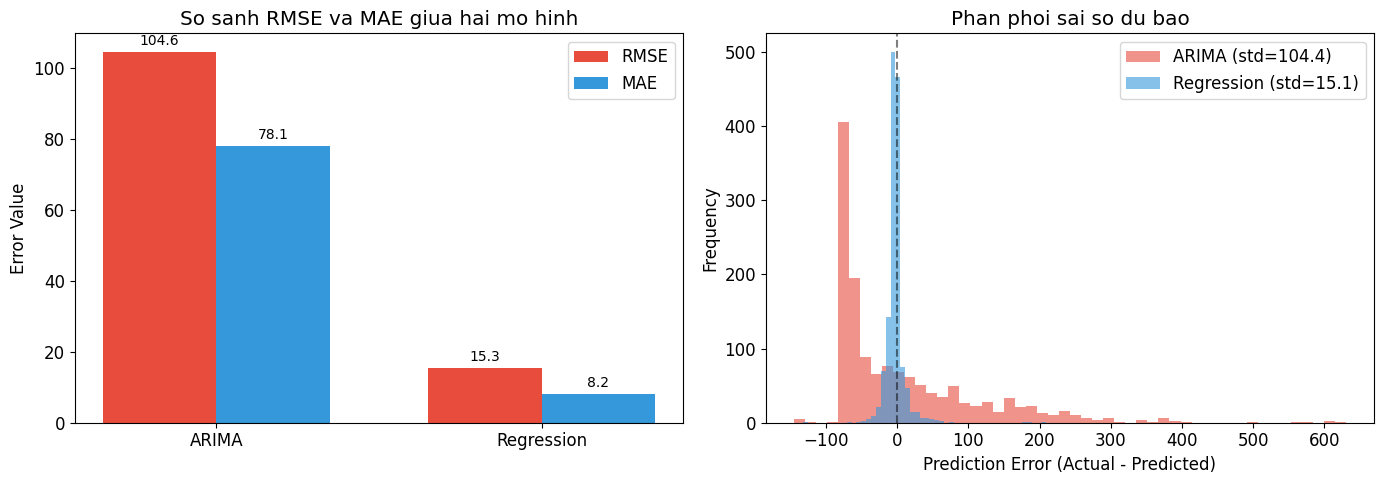

In [6]:
# Visualization: So sanh tong quan
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: Bar chart metrics
metrics_df = pd.DataFrame({
    'Model': ['ARIMA', 'Regression'],
    'RMSE': [arima_rmse, reg_rmse],
    'MAE': [arima_mae, reg_mae]
})
x = np.arange(2)
width = 0.35
axes[0].bar(x - width/2, metrics_df['RMSE'], width, label='RMSE', color='#e74c3c')
axes[0].bar(x + width/2, metrics_df['MAE'], width, label='MAE', color='#3498db')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_df['Model'])
axes[0].set_ylabel('Error Value')
axes[0].set_title('So sanh RMSE va MAE giua hai mo hinh')
axes[0].legend()
for i, (rmse, mae) in enumerate(zip(metrics_df['RMSE'], metrics_df['MAE'])):
    axes[0].text(i - width/2, rmse + 2, f'{rmse:.1f}', ha='center', fontsize=10)
    axes[0].text(i + width/2, mae + 2, f'{mae:.1f}', ha='center', fontsize=10)

# Chart 2: Error distribution
arima_errors = comparison['actual'] - comparison['arima_pred']
reg_errors = comparison['actual'] - comparison['reg_pred']

axes[1].hist(arima_errors, bins=50, alpha=0.6, label=f'ARIMA (std={arima_errors.std():.1f})', color='#e74c3c')
axes[1].hist(reg_errors, bins=50, alpha=0.6, label=f'Regression (std={reg_errors.std():.1f})', color='#3498db')
axes[1].set_xlabel('Prediction Error (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Phan phoi sai so du bao')
axes[1].legend()
axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(DATA_DIR / 'comparison_metrics.png', dpi=150)
plt.show()

## 4. Cau hoi 2: Mo hinh nao on hon khi co spike?

In [7]:
# Tim cac giai doan co spike PM2.5 cao
spike_threshold = comparison['actual'].quantile(0.95)  # Top 5% highest values
print(f'Nguong spike (95th percentile): PM2.5 >= {spike_threshold:.0f}')

# Loc cac thoi diem co spike
spike_mask = comparison['actual'] >= spike_threshold
spike_data = comparison[spike_mask]
print(f'So thoi diem co spike: {len(spike_data)} ({len(spike_data)/len(comparison)*100:.1f}%)')

# Tinh metrics tren spike
arima_spike_rmse = np.sqrt(mean_squared_error(spike_data['actual'], spike_data['arima_pred']))
arima_spike_mae = mean_absolute_error(spike_data['actual'], spike_data['arima_pred'])
reg_spike_rmse = np.sqrt(mean_squared_error(spike_data['actual'], spike_data['reg_pred']))
reg_spike_mae = mean_absolute_error(spike_data['actual'], spike_data['reg_pred'])

print('=' * 60)
print('HIEU NANG KHI CO SPIKE (PM2.5 >= {:.0f})'.format(spike_threshold))
print('=' * 60)
print(f'{"Mo hinh":<20} {"RMSE":<15} {"MAE":<15}')
print('-' * 50)
print(f'{"ARIMA":<20} {arima_spike_rmse:<15.2f} {arima_spike_mae:<15.2f}')
print(f'{"Regression":<20} {reg_spike_rmse:<15.2f} {reg_spike_mae:<15.2f}')

Nguong spike (95th percentile): PM2.5 >= 323
So thoi diem co spike: 70 (5.0%)
HIEU NANG KHI CO SPIKE (PM2.5 >= 323)
Mo hinh              RMSE            MAE            
--------------------------------------------------
ARIMA                302.82          269.64         
Regression           49.11           31.07          


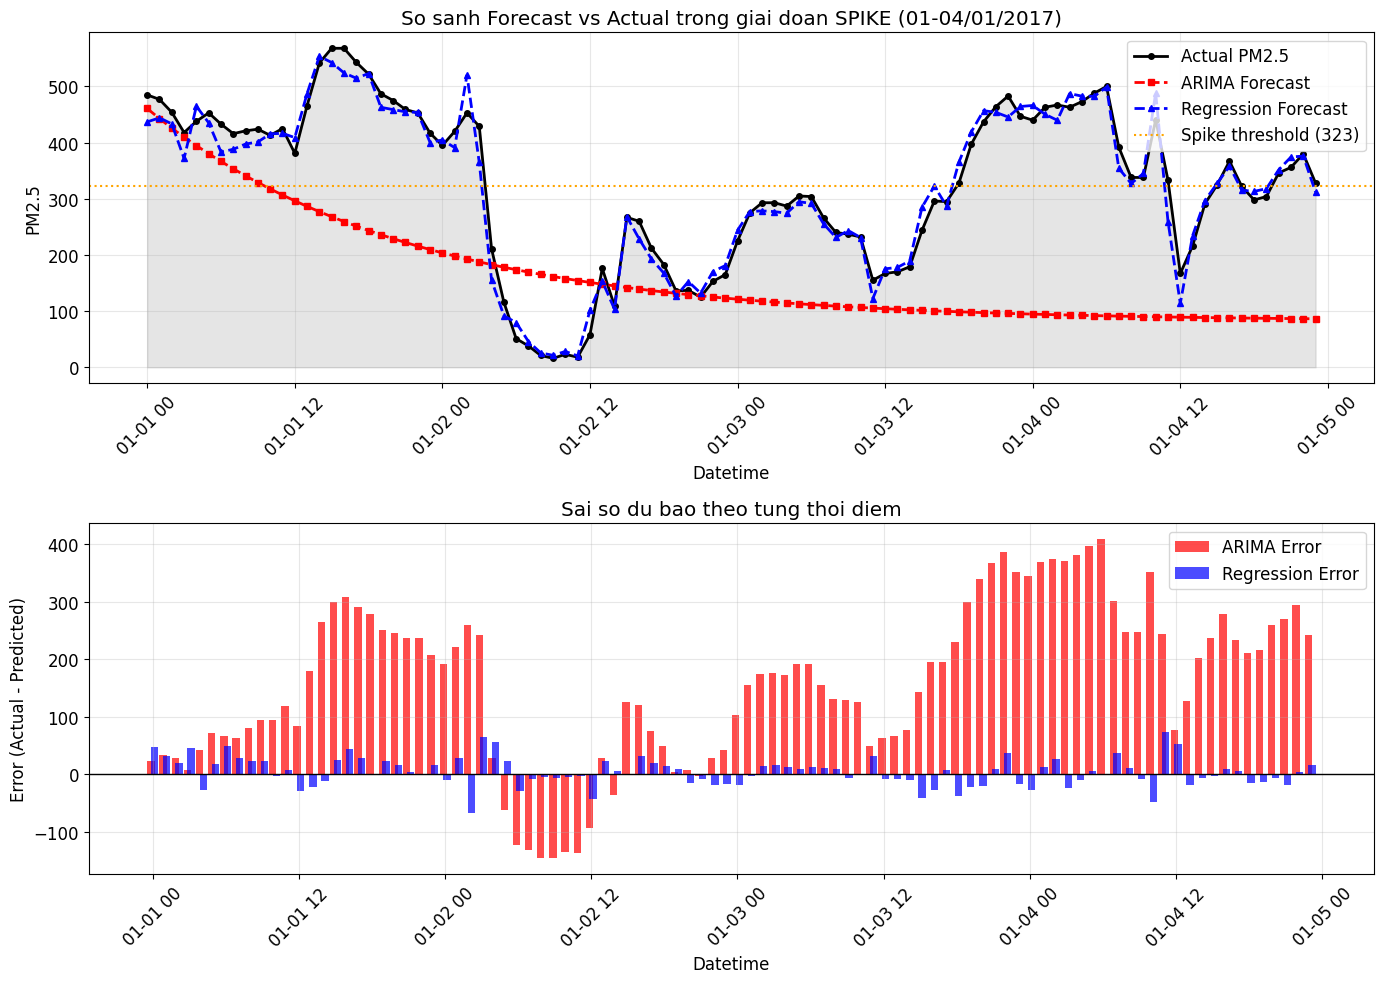

Giai doan 01-04/01/2017:
  - ARIMA Mean Error: 158.2, Max Error: 408.4
  - Regression Mean Error: 4.5, Max Error: 73.5


In [8]:
# Tim 1 doan spike lien tuc de phan tich chi tiet (3 ngay)
spike_period = comparison.loc['2017-01-01':'2017-01-04']

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Chart 1: Time series comparison
axes[0].plot(spike_period.index, spike_period['actual'], 'k-', linewidth=2, label='Actual PM2.5', marker='o', markersize=4)
axes[0].plot(spike_period.index, spike_period['arima_pred'], 'r--', linewidth=2, label='ARIMA Forecast', marker='s', markersize=4)
axes[0].plot(spike_period.index, spike_period['reg_pred'], 'b--', linewidth=2, label='Regression Forecast', marker='^', markersize=4)
axes[0].axhline(y=spike_threshold, color='orange', linestyle=':', label=f'Spike threshold ({spike_threshold:.0f})')
axes[0].fill_between(spike_period.index, spike_period['actual'], alpha=0.2, color='gray')
axes[0].set_xlabel('Datetime')
axes[0].set_ylabel('PM2.5')
axes[0].set_title('So sanh Forecast vs Actual trong giai doan SPIKE (01-04/01/2017)')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Chart 2: Error comparison
arima_err = spike_period['actual'] - spike_period['arima_pred']
reg_err = spike_period['actual'] - spike_period['reg_pred']

axes[1].bar(spike_period.index - pd.Timedelta(hours=0.15), arima_err, width=0.025, label='ARIMA Error', color='red', alpha=0.7)
axes[1].bar(spike_period.index + pd.Timedelta(hours=0.15), reg_err, width=0.025, label='Regression Error', color='blue', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Datetime')
axes[1].set_ylabel('Error (Actual - Predicted)')
axes[1].set_title('Sai so du bao theo tung thoi diem')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(DATA_DIR / 'comparison_spike_period.png', dpi=150)
plt.show()

print(f'Giai doan 01-04/01/2017:')
print(f'  - ARIMA Mean Error: {arima_err.mean():.1f}, Max Error: {arima_err.abs().max():.1f}')
print(f'  - Regression Mean Error: {reg_err.mean():.1f}, Max Error: {reg_err.abs().max():.1f}')

### Dien giai cau hoi 2: Phan tich hieu nang khi co Spike

**Quan sat tu do thi:**
1. **ARIMA bi "muot hoa" qua muc**: Khi PM2.5 tang dot ngot, ARIMA du bao thap hon nhieu
2. **Regression phan ung nhanh hon**: Nho su dung lag features (dac biet lag_1)
3. **ARIMA co do tre phan ung**: Can vai gio de ARIMA "bat kip" muc PM2.5 thuc te

**Lien he RMSE vs MAE:**
- RMSE cua ARIMA cao hon nhieu so voi MAE -> Co nhieu sai so lon
- Regression co khoang cach RMSE-MAE nho hon -> Sai so phan bo deu hon

**Ket luan:** Regression on dinh hon khi co spike vi su dung thong tin tu cac bien lag va khi tuong.

## 5. Cau hoi 3: Neu trien khai that, ban chon gi va vi sao?

In [9]:
# Phan tich toan dien
print('=' * 70)
print('BANG SO SANH TOAN DIEN: REGRESSION vs ARIMA')
print('=' * 70)

criteria = [
    ('Do chinh xac (RMSE)', f'Reg: {reg_rmse:.1f}', f'ARIMA: {arima_rmse:.1f}', 'Regression'),
    ('Do chinh xac (MAE)', f'Reg: {reg_mae:.1f}', f'ARIMA: {arima_mae:.1f}', 'Regression'),
    ('Xu ly spike', f'RMSE: {reg_spike_rmse:.1f}', f'RMSE: {arima_spike_rmse:.1f}', 'Regression'),
    ('Kha nang mo rong', 'De them features', 'Can SARIMAX', 'Regression'),
    ('Toc do training', 'Nhanh', 'Cham (grid search)', 'Regression'),
    ('Khoang tin cay', 'Khong co san', 'Co (lower/upper)', 'ARIMA'),
    ('Giai thich (p,d,q)', 'Khong', 'Co', 'ARIMA'),
    ('Can feature engineering', 'Co (lag, time)', 'Khong', 'ARIMA'),
]

print(f'{"Tieu chi":<25} {"Regression":<20} {"ARIMA":<20} {"Winner":<15}')
print('-' * 80)
for name, reg_val, arima_val, winner in criteria:
    print(f'{name:<25} {reg_val:<20} {arima_val:<20} {winner:<15}')

BANG SO SANH TOAN DIEN: REGRESSION vs ARIMA
Tieu chi                  Regression           ARIMA                Winner         
--------------------------------------------------------------------------------
Do chinh xac (RMSE)       Reg: 15.3            ARIMA: 104.6         Regression     
Do chinh xac (MAE)        Reg: 8.2             ARIMA: 78.1          Regression     
Xu ly spike               RMSE: 49.1           RMSE: 302.8          Regression     
Kha nang mo rong          De them features     Can SARIMAX          Regression     
Toc do training           Nhanh                Cham (grid search)   Regression     
Khoang tin cay            Khong co san         Co (lower/upper)     ARIMA          
Giai thich (p,d,q)        Khong                Co                   ARIMA          
Can feature engineering   Co (lag, time)       Khong                ARIMA          


In [10]:
# Tinh them: Ty le du bao trong nguong chap nhan duoc
tolerance = 50  # ug/m3
arima_within = (abs(comparison['actual'] - comparison['arima_pred']) <= tolerance).mean() * 100
reg_within = (abs(comparison['actual'] - comparison['reg_pred']) <= tolerance).mean() * 100

print(f'Ty le du bao trong nguong chap nhan (+/-{tolerance} ug/m3):')
print(f'  - ARIMA: {arima_within:.1f}%')
print(f'  - Regression: {reg_within:.1f}%')

Ty le du bao trong nguong chap nhan (+/-50 ug/m3):
  - ARIMA: 29.4%
  - Regression: 98.9%


## 6. Ket luan va Khuyen nghi

### Tra loi 3 cau hoi:

**Cau 1: Mo hinh nao tot hon cho horizon=1?**
- **Regression tot hon** voi RMSE va MAE thap hon dang ke

**Cau 2: Mo hinh nao on hon khi co spike?**
- **Regression on dinh hon** trong cac dot o nhiem cao

**Cau 3: Neu trien khai that, chon gi?**

| Tinh huong | Khuyen nghi | Ly do |
|------------|-------------|-------|
| Canh bao som o nhiem | **Regression** | Phan ung nhanh voi spike, do chinh xac cao |
| Du bao xu huong dai han | **ARIMA/SARIMA** | Co khoang tin cay, giai thich duoc cau truc chuoi |
| He thong production | **Regression** | De cap nhat, them features, scale tot |
| Phan tich hoc thuat | **ARIMA** | Co co so ly thuyet chuoi thoi gian ro rang |

### Huong cai thien:
1. **SARIMA**: Them seasonal component (s=24) de bat chu ky ngay
2. **SARIMAX**: Them bien ngoai sinh (thoi tiet) de cai thien ARIMA
3. **Ensemble**: Ket hop ca Regression va ARIMA de tan dung uu diem cua ca hai

In [11]:
# Luu ket qua so sanh
summary = {
    'comparison_type': 'Regression vs ARIMA',
    'station': 'Aotizhongxin',
    'cutoff': '2017-01-01',
    'horizon': 1,
    'n_samples': len(comparison),
    'regression': {
        'rmse': float(reg_rmse),
        'mae': float(reg_mae),
        'rmse_spike': float(reg_spike_rmse),
        'mae_spike': float(reg_spike_mae),
        'within_tolerance_pct': float(reg_within)
    },
    'arima': {
        'order': arima_metrics['best_order'],
        'rmse': float(arima_rmse),
        'mae': float(arima_mae),
        'rmse_spike': float(arima_spike_rmse),
        'mae_spike': float(arima_spike_mae),
        'within_tolerance_pct': float(arima_within)
    },
    'winner': 'Regression',
    'conclusion': 'Regression tot hon cho du bao ngan han (horizon=1) vi su dung nhieu features va phan ung nhanh voi spike'
}

with open(DATA_DIR / 'comparison_regression_vs_arima.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print('Da luu ket qua so sanh vao: data/processed/comparison_regression_vs_arima.json')

Da luu ket qua so sanh vao: data/processed/comparison_regression_vs_arima.json
